# Running on new images
This notebook will walk you step by step through the process of using a pre-trained model to detect traffic signs in an image.

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import glob as glob
import pandas as pd
import fnmatch

# Environment setup

In [2]:
%matplotlib inline
import sys
# Append your Tensorflow object detection and darkflow directories to your path
sys.path.append('/Users/ramyavunikili/.local/lib/python3.6/site-packages/tensorflow/models/research/object_detection/') # ~/tensorflow/models/research/object_detection
sys.path.append('/Users/ramyavunikili/Courses/Computer Vision/Project/Traffic_sign_detection_YOLO-master/darkflow/darkflow/') # ~/darkflow
from utils import label_map_util
from utils import visualization_utils as vis_util

# Tensorflow Object Detection API

## Model preparation 

In [3]:
#MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
# MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
# MODEL_NAME = 'faster_rcnn_inception_v2'
MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'

In [4]:
# Path to frozen detection graph. This is the actual model that is used for the traffic sign detection.
MODEL_PATH = os.path.join('models', MODEL_NAME)
PATH_TO_CKPT = os.path.join(MODEL_PATH,'inference_graph/frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('scripts', 'gtsdb3_label_map.pbtxt')

NUM_CLASSES = 3

## Load a (frozen) Tensorflow model into memory

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `2`, we know that this corresponds to `mandatory`.

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(label_map)

item {
  name: "prohibitory"
  id: 1
}
item {
  name: "mandatory"
  id: 2
}
item {
  name: "danger"
  id: 3
}



## Helper code

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

## Detection

In [21]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PROJECT_PATH = '/Users/ramyavunikili/Courses/Computer Vision/Project/traffic-sign-detection-master/'
PATH_TO_TEST_IMAGES_DIR = 'test_images/'
#TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.png', recursive=True))

TEST_IMAGE_PATHS = []
for root, dirnames, filenames in os.walk(PROJECT_PATH+PATH_TO_TEST_IMAGES_DIR):
    for filename in fnmatch.filter(filenames, '*.png'):
        TEST_IMAGE_PATHS.append(os.path.join(root, filename))
        
# Size, in inches, of the output images.
IMAGE_SIZE = (20, 20)
headers = ['category', 'folder_path', 'xmin', 'xmax', 'ymin', 'ymax', 'class', 'score', 'total']
result_df = pd.DataFrame(columns=headers)

In [22]:
#result_df = pd.DataFrame(columns=['category', 'folder_path', 'xmin', 'xmax', 'ymin', 'ymax', 'class', 'score', 'total'])
TEST_IMAGE_PATHS

['/Users/ramyavunikili/Courses/Computer Vision/Project/traffic-sign-detection-master/test_images/dummy/1/0000000248.png',
 '/Users/ramyavunikili/Courses/Computer Vision/Project/traffic-sign-detection-master/test_images/dummy/2/2.png']

dummy/1/0000000248.png
dummy/2/2.png


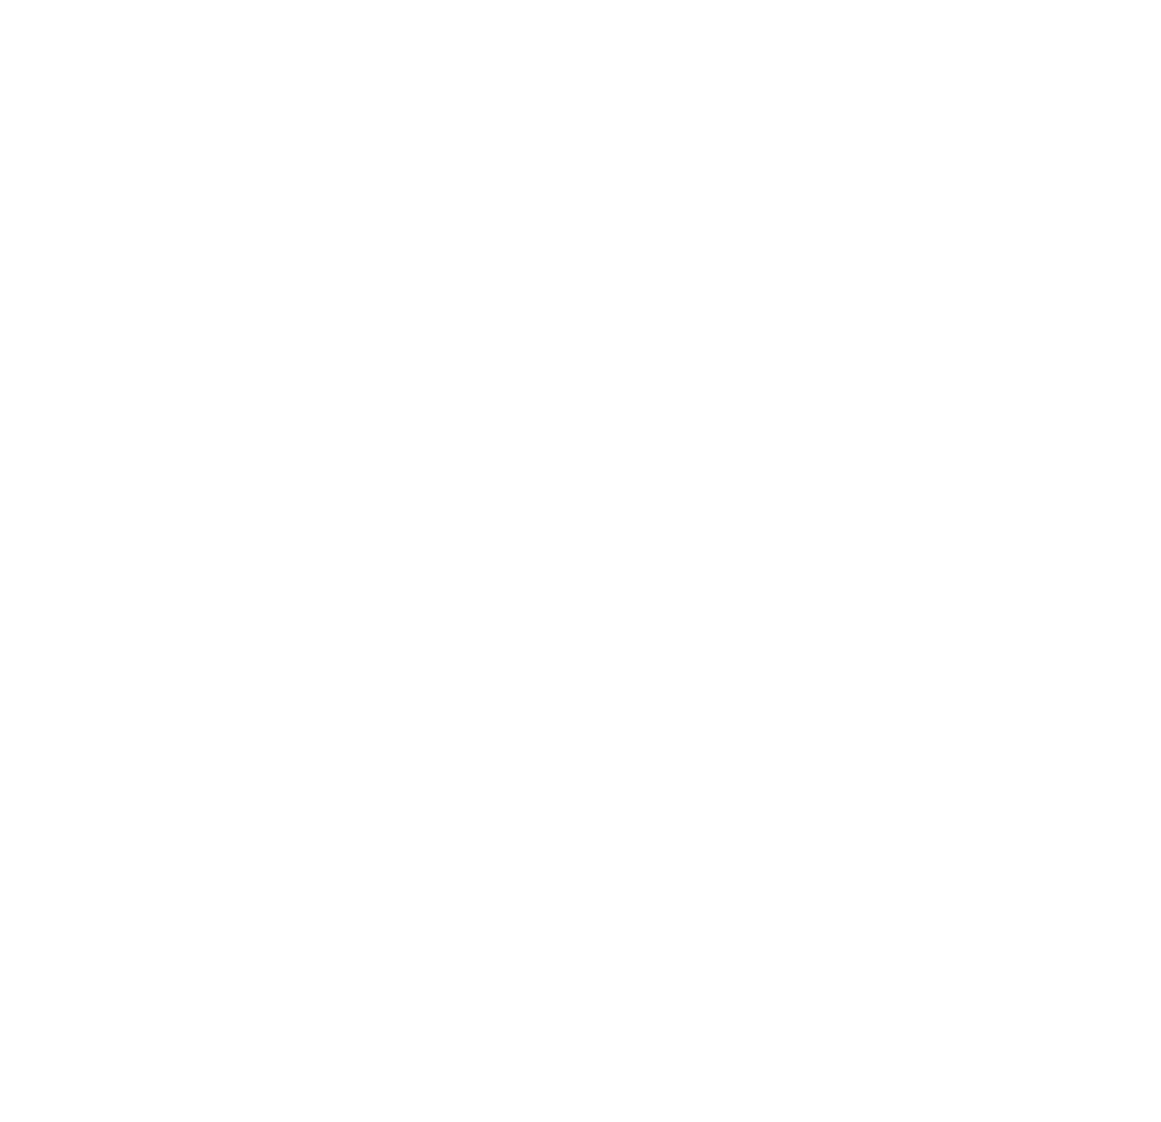

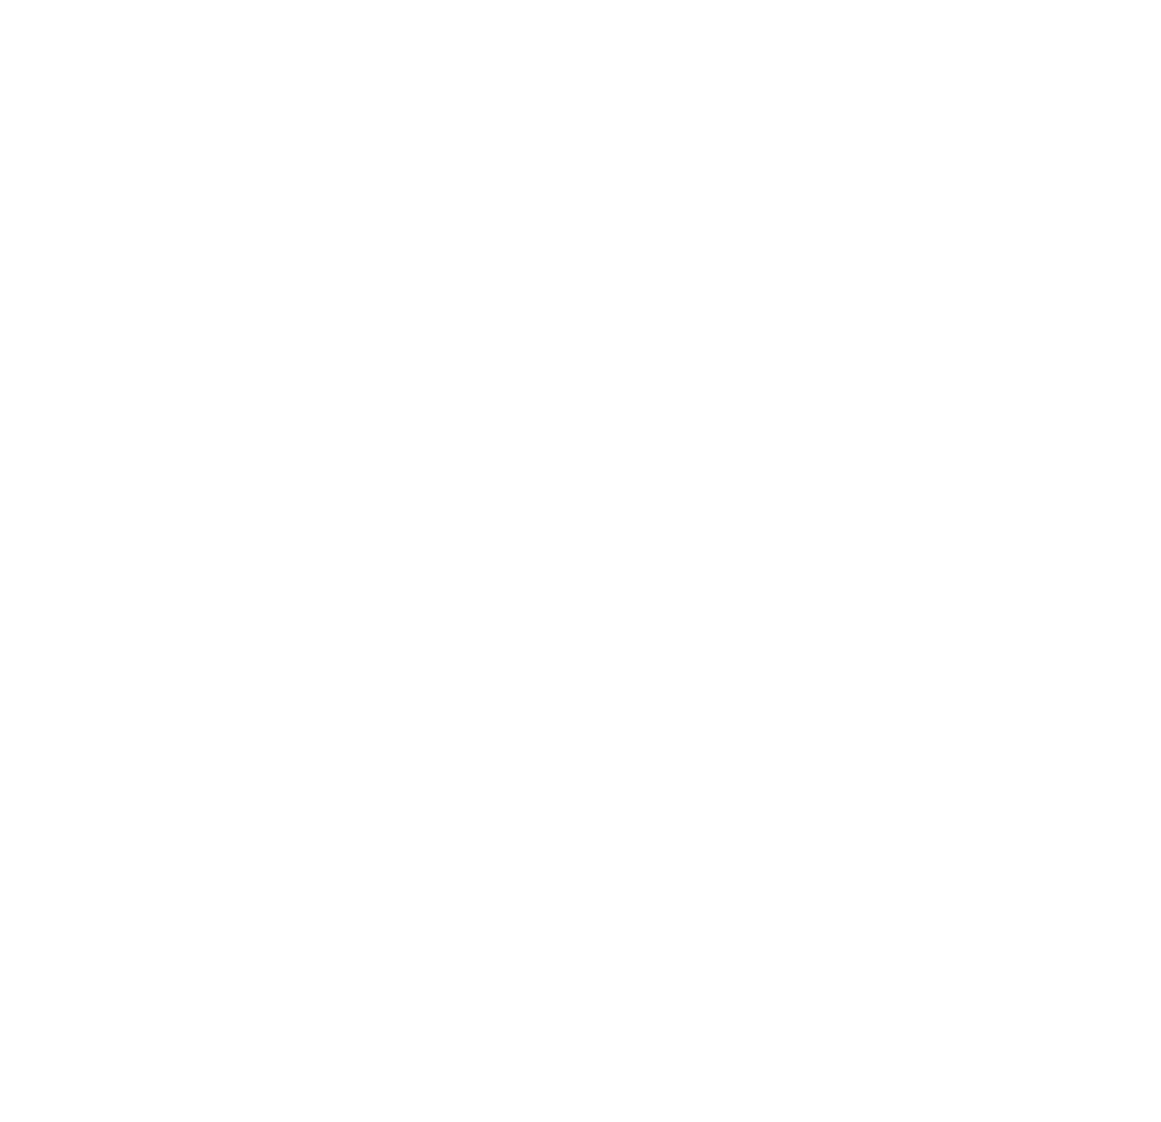

In [23]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for idx, image_path in enumerate(TEST_IMAGE_PATHS):
            image_path_trimmed = image_path.split(PATH_TO_TEST_IMAGES_DIR)[1]
            print(image_path_trimmed)
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            plt.figure(idx, figsize=IMAGE_SIZE)
            plt.axis('off')
            #plt.imshow(image_np)
            
            coordinate_list = vis_util.return_coordinates(image_np, np.squeeze(boxes), 
                                                          np.squeeze(classes).astype(np.int32),
                                                          np.squeeze(scores), category_index, 
                                                          use_normalized_coordinates = True,
                                                          line_thickness=6)
            if (len(coordinate_list) > 0):
                plt.imsave(PROJECT_PATH+'road_output/'+image_path_trimmed, image_np)
                for box in coordinate_list:
                    output_list = ['Road', image_path_trimmed] + box
                    result_df = result_df.append(dict(zip(headers, output_list)), ignore_index=True)
                result_df.to_csv(PROJECT_PATH+'road_output.csv', sep='\t', index=False)

In [24]:
result_df = pd.read_csv(PROJECT_PATH+'road_output.csv', sep='\t')
result_df.head()

,category,folder_path,xmin,xmax,ymin,ymax,class,score,total
0,Road,dummy/1/0000000248.png,764,807,97,138,['prohibitory: 99%'],99.99994,2
1,Road,dummy/1/0000000248.png,135,162,140,163,['danger: 99%'],99.99820,2
2,Road,dummy/2/2.png,764,807,97,138,['prohibitory: 99%'],99.99994,2
3,Road,dummy/2/2.png,135,162,140,163,['danger: 99%'],99.99820,2


# Darkflow

## Model preparation 

In [31]:
from darkflow.net.build import TFNet
import cv2

MODEL_NAME = 'yolo_v2'
MODEL_PATH = os.path.join('/Users/ramyavunikili/Courses/Computer Vision/Project/traffic-sign-detection-master/models/', MODEL_NAME)

options = {'model': os.path.join(MODEL_PATH, '{}.cfg'.format(MODEL_NAME)),
           'labels': os.path.join(MODEL_PATH, 'labels.txt'),
           'backup': MODEL_PATH,
           'load' : 50500,
           'threshold': 0.5,
           'gpu' : 1.0}

tfnet = TFNet(options)

Parsing /Users/ramyavunikili/Courses/Computer Vision/Project/traffic-sign-detection-master/models/yolo_v2/yolo_v2.cfg
Loading None ...
Finished in 0.00011992454528808594s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm 

NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

/Users/ramyavunikili/Courses/Computer Vision/Project/traffic-sign-detection-master/models/yolo_v2/yolo_v2-50500.data-00000-of-00001; No such file or directory
	 [[node save/RestoreV2_132 (defined at /Users/ramyavunikili/Courses/Computer Vision/Project/Traffic_sign_detection_YOLO-master/darkflow/darkflow/utils/loader.py:89)  = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_132/tensor_names, save/RestoreV2_132/shape_and_slices)]]

Caused by op 'save/RestoreV2_132', defined at:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-750713a47daa>", line 14, in <module>
    tfnet = TFNet(options)
  File "/Users/ramyavunikili/Courses/Computer Vision/Project/Traffic_sign_detection_YOLO-master/darkflow/darkflow/net/build.py", line 76, in __init__
    self.setup_meta_ops()
  File "/Users/ramyavunikili/Courses/Computer Vision/Project/Traffic_sign_detection_YOLO-master/darkflow/darkflow/net/build.py", line 151, in setup_meta_ops
    if self.FLAGS.load != 0: self.load_from_ckpt()
  File "/Users/ramyavunikili/Courses/Computer Vision/Project/Traffic_sign_detection_YOLO-master/darkflow/darkflow/net/help.py", line 34, in load_from_ckpt
    except: load_old_graph(self, load_point)
  File "/Users/ramyavunikili/Courses/Computer Vision/Project/Traffic_sign_detection_YOLO-master/darkflow/darkflow/net/help.py", line 45, in load_old_graph
    ckpt_loader = create_loader(ckpt)
  File "/Users/ramyavunikili/Courses/Computer Vision/Project/Traffic_sign_detection_YOLO-master/darkflow/darkflow/utils/loader.py", line 105, in create_loader
    return load_type(path, cfg)
  File "/Users/ramyavunikili/Courses/Computer Vision/Project/Traffic_sign_detection_YOLO-master/darkflow/darkflow/utils/loader.py", line 19, in __init__
    self.load(*args)
  File "/Users/ramyavunikili/Courses/Computer Vision/Project/Traffic_sign_detection_YOLO-master/darkflow/darkflow/utils/loader.py", line 89, in load
    saver = tf.train.import_meta_graph(meta)
  File "/Users/ramyavunikili/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1674, in import_meta_graph
    meta_graph_or_file, clear_devices, import_scope, **kwargs)[0]
  File "/Users/ramyavunikili/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1696, in _import_meta_graph_with_return_elements
    **kwargs))
  File "/Users/ramyavunikili/.local/lib/python3.6/site-packages/tensorflow/python/framework/meta_graph.py", line 806, in import_scoped_meta_graph_with_return_elements
    return_elements=return_elements)
  File "/Users/ramyavunikili/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Users/ramyavunikili/.local/lib/python3.6/site-packages/tensorflow/python/framework/importer.py", line 442, in import_graph_def
    _ProcessNewOps(graph)
  File "/Users/ramyavunikili/.local/lib/python3.6/site-packages/tensorflow/python/framework/importer.py", line 234, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "/Users/ramyavunikili/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3440, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "/Users/ramyavunikili/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3440, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "/Users/ramyavunikili/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3299, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "/Users/ramyavunikili/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

/Users/ramyavunikili/Courses/Computer Vision/Project/traffic-sign-detection-master/models/yolo_v2/yolo_v2-50500.data-00000-of-00001; No such file or directory
	 [[node save/RestoreV2_132 (defined at /Users/ramyavunikili/Courses/Computer Vision/Project/Traffic_sign_detection_YOLO-master/darkflow/darkflow/utils/loader.py:89)  = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_132/tensor_names, save/RestoreV2_132/shape_and_slices)]]


## Helper code

In [ ]:
def plot_rectangle(bbox, ax, class_name, edgecolor, confidence=None):
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    left = xmin
    right = xmax
    top = ymin
    bot = ymax
    ax.add_patch(
        plt.Rectangle((left, top),
                      right-left,
                      bot-top, fill=False,
                      edgecolor=edgecolor, linewidth=3.5)
        )
    label = '{:s}'.format(class_name)
    label_pos_y = top-10
    if confidence:
        label += ' {0:.2f}'.format(confidence)
        label_pos_y = bot+20
    ax.text(left, label_pos_y,label,
            bbox=dict(facecolor=edgecolor, alpha=0.5),
            fontsize=14, color='white')

In [12]:
def get_label_id(label_name):
    for category in categories:
        if category['name'] == label_name:
            return category['id']

## Detection

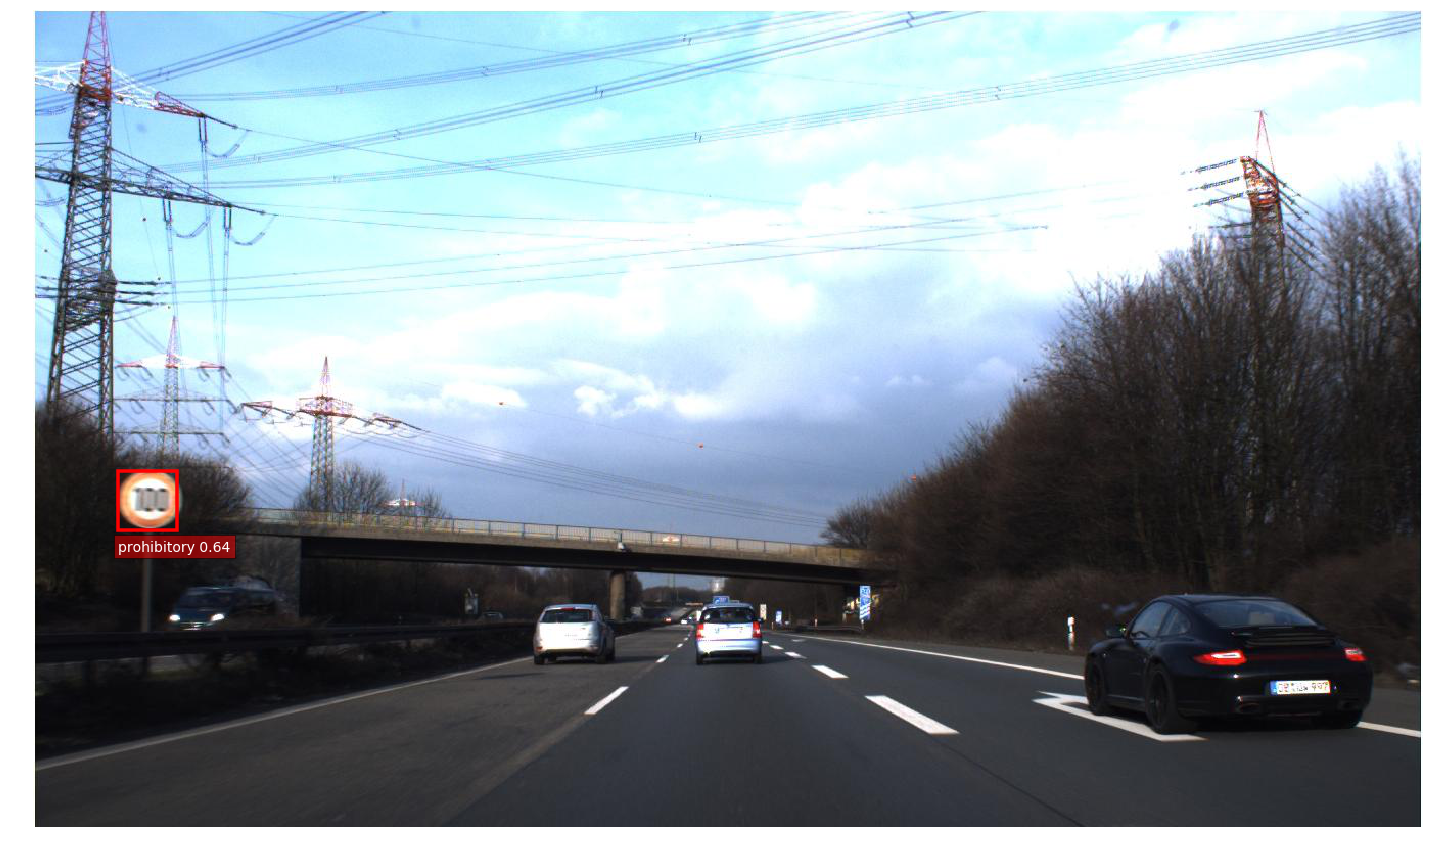

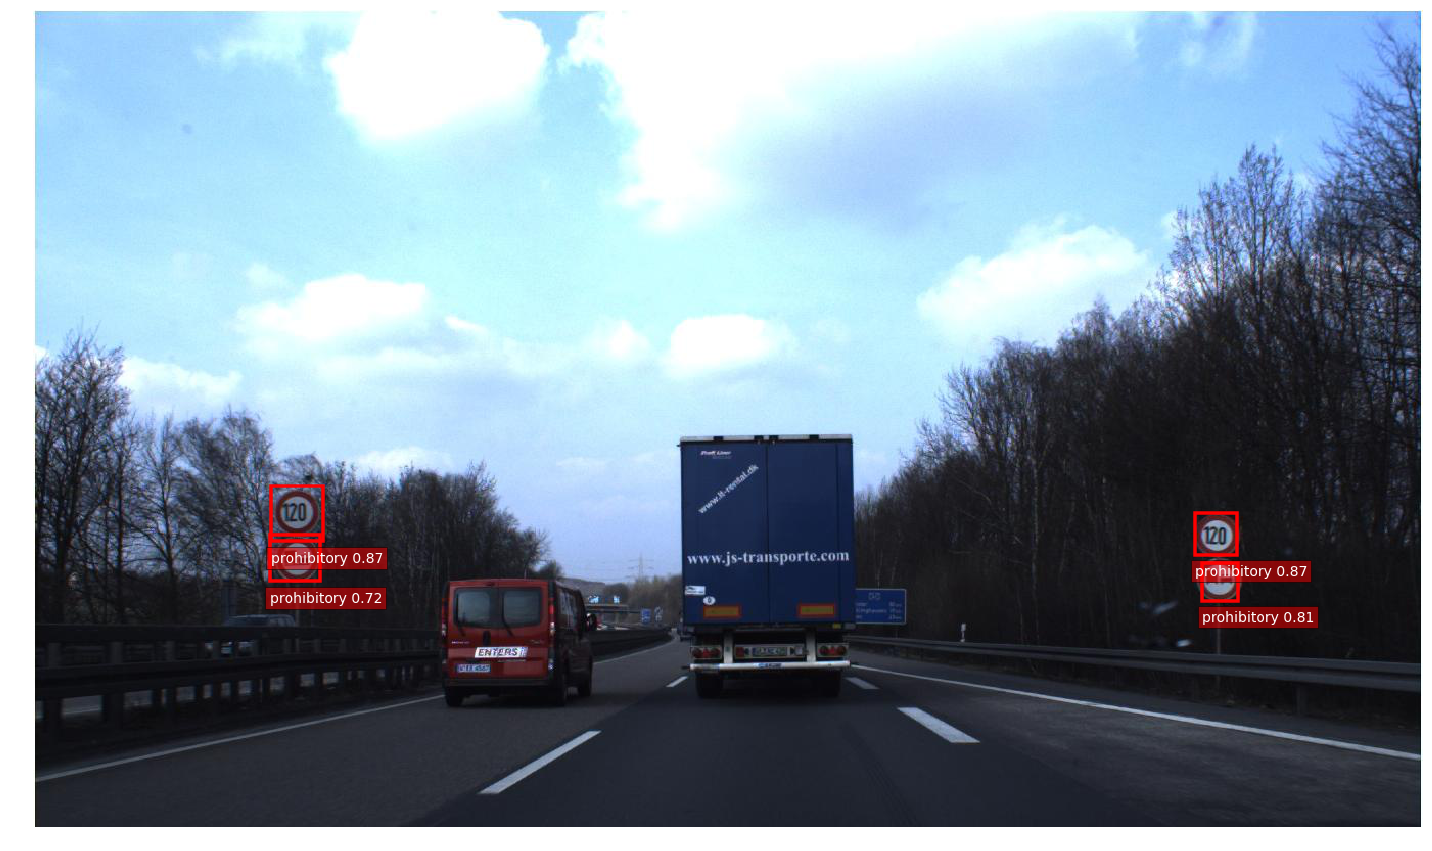

In [13]:
min_score_thresh = 0.5
for image_path in TEST_IMAGE_PATHS:
    fig, ax = plt.subplots(figsize=(20, 20))
    image = Image.open(image_path)
    image_name = os.path.basename(image_path)
    width, height = image.size
    ax.imshow(image)
    
    image_np = load_image_into_numpy_array(image)
    image_np = image_np[:,:,::-1] # rgb -> bgr
    pred_results = tfnet.return_predict(image_np)

    for idx, det in enumerate(pred_results):
        score = det['confidence']
        if score > min_score_thresh:
            bbox = det['topleft']['x'], det['topleft']['y'], det['bottomright']['x'], det['bottomright']['y']
            label = get_label_id(det['label'])
            plot_rectangle(bbox,ax,category_index[label]['name'],'red', score)
    plt.draw()
    fig.tight_layout()
    plt.axis('off')
    plt.show()